# Import

#### Install the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import furniture
import numpy as np
import time
import imgaug
import imgaug.augmenters as aug
from mrcnn import visualize
import mrcnn.utils as utils
from mrcnn.config import Config
from tensorflow.keras.callbacks import TensorBoard
import mrcnn.model as modellib

%matplotlib inline

Using TensorFlow backend.


# Initialize
##### Set up the folder path:

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# For TensorBoard
NAME = 'Mask-RCNN-furniture-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
# Download COCO trained weights from Releases if needed
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

DATA_DIR = os.path.join(ROOT_DIR, "dataset/")

##### Configuration:

In [3]:
class FinalConfig(furniture.FurnitureConfig):

    IMAGE_MAX_DIM = 512
    IMAGE_MIN_DIM = 512
    
    POST_NMS_ROIS_TRAINING = 10
    
    DETECTION_MIN_CONFIDENCE = 0.8
    
    BACKBONE = 'resnet50'
    
    
config = FinalConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

##### Configuration for baseline

# Load Data
##### load the training data and testing data

In [4]:
dataset_train = furniture.FurnitureDataset()
dataset_train.load_data('./dataset/train/coco.json', './dataset/train/')
dataset_train.prepare()

dataset_val = furniture.FurnitureDataset()
dataset_val.load_data('./dataset/val/coco.json', './dataset/val/')
dataset_val.prepare()

# Data Augmentation

In [5]:
augmentation = imgaug.augmenters.Sometimes(1 / 2, aug.OneOf(
    [
        imgaug.augmenters.Fliplr(1),
        imgaug.augmenters.Flipud(1),
        imgaug.augmenters.Affine(rotate=(-45, 45)),
        imgaug.augmenters.Affine(rotate=(-90, 90)),
        imgaug.augmenters.Affine(scale=(0.5, 1.5))
    ]
))

# Display the image
##### Randomly pick up some image and display it

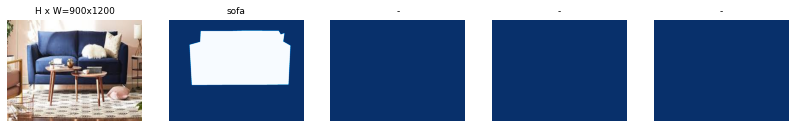

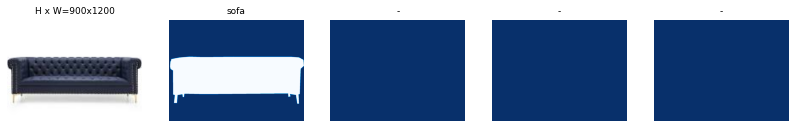

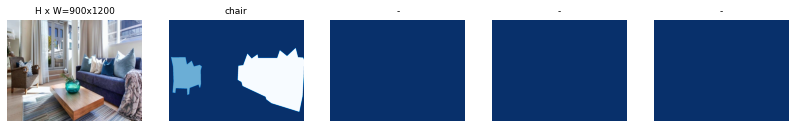

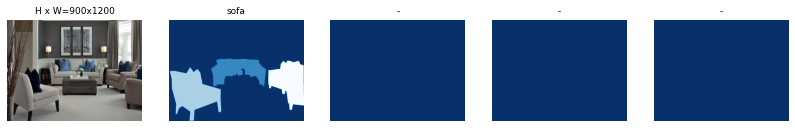

In [6]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create model
##### load the model by using Mask-rcnn backbone

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

##### load the COCO weight

In [8]:
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Train the model

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=200,
            layers="all",
            custom_callbacks=[tensorboard],
            augmentation=augmentation)

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\python\mask\logs\furniture20200425T2124\mask_rcnn_furniture_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch

Epoch 32/200
100/100 [==============================] - 122s 1s/step - loss: 0.8633 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2033 - val_loss: 0.8980 - val_rpn_class_loss: 0.0127 - val_rpn_bbox_loss: 0.4612 - val_mrcnn_class_loss: 0.1225 - val_mrcnn_bbox_loss: 0.1103 - val_mrcnn_mask_loss: 0.1913
Epoch 33/200
100/100 [==============================] - 122s 1s/step - loss: 0.8704 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4175 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.2211 - val_loss: 1.1095 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.5790 - val_mrcnn_class_loss: 0.0934 - val_mrcnn_bbox_loss: 0.1919 - val_mrcnn_mask_loss: 0.2382
Epoch 34/200
100/100 [==============================] - 122s 1s/step - loss: 0.8878 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4170 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2192 - val_loss: 0.9882 - val_rpn_c

Epoch 54/200
100/100 [==============================] - 123s 1s/step - loss: 0.6536 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2019 - val_loss: 1.1048 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.4889 - val_mrcnn_class_loss: 0.1244 - val_mrcnn_bbox_loss: 0.1853 - val_mrcnn_mask_loss: 0.2992
Epoch 55/200
100/100 [==============================] - 122s 1s/step - loss: 0.6219 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1955 - val_loss: 0.9220 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.4741 - val_mrcnn_class_loss: 0.0503 - val_mrcnn_bbox_loss: 0.1459 - val_mrcnn_mask_loss: 0.2442
Epoch 56/200
100/100 [==============================] - 123s 1s/step - loss: 0.6691 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.3228 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1815 - val_loss: 0.9424 - val_rpn_c

Epoch 76/200
100/100 [==============================] - 127s 1s/step - loss: 0.6002 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1708 - val_loss: 1.0908 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 0.7328 - val_mrcnn_class_loss: 0.0912 - val_mrcnn_bbox_loss: 0.0883 - val_mrcnn_mask_loss: 0.1655
Epoch 77/200
100/100 [==============================] - 127s 1s/step - loss: 0.6276 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.2872 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1838 - val_loss: 0.7438 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.4366 - val_mrcnn_class_loss: 0.0365 - val_mrcnn_bbox_loss: 0.0701 - val_mrcnn_mask_loss: 0.1938
Epoch 78/200
100/100 [==============================] - 126s 1s/step - loss: 0.5929 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.3054 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1583 - val_loss: 1.0472 - val_rpn_c

Epoch 98/200
100/100 [==============================] - 134s 1s/step - loss: 0.4785 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1457 - val_loss: 1.0035 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.4889 - val_mrcnn_class_loss: 0.1889 - val_mrcnn_bbox_loss: 0.1133 - val_mrcnn_mask_loss: 0.2069
Epoch 99/200
100/100 [==============================] - 137s 1s/step - loss: 0.5196 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2340 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1573 - val_loss: 0.7998 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.4472 - val_mrcnn_class_loss: 0.0607 - val_mrcnn_bbox_loss: 0.1140 - val_mrcnn_mask_loss: 0.1614
Epoch 100/200
100/100 [==============================] - 134s 1s/step - loss: 0.5152 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1603 - val_loss: 1.2554 - val_rpn_

Epoch 120/200
100/100 [==============================] - 128s 1s/step - loss: 0.4227 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1303 - val_loss: 1.0298 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.6033 - val_mrcnn_class_loss: 0.1129 - val_mrcnn_bbox_loss: 0.1535 - val_mrcnn_mask_loss: 0.1525
Epoch 121/200
100/100 [==============================] - 127s 1s/step - loss: 0.3942 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1757 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1373 - val_loss: 1.0924 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.4615 - val_mrcnn_class_loss: 0.2001 - val_mrcnn_bbox_loss: 0.1873 - val_mrcnn_mask_loss: 0.2408
Epoch 122/200
100/100 [==============================] - 127s 1s/step - loss: 0.4450 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1457 - val_loss: 0.7153 - val_rp

Epoch 142/200
100/100 [==============================] - 127s 1s/step - loss: 0.3795 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1480 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1400 - val_loss: 1.2597 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.6009 - val_mrcnn_class_loss: 0.1310 - val_mrcnn_bbox_loss: 0.1434 - val_mrcnn_mask_loss: 0.3769
Epoch 143/200
100/100 [==============================] - 126s 1s/step - loss: 0.3759 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1763 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1300 - val_loss: 0.6410 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.2880 - val_mrcnn_class_loss: 0.0509 - val_mrcnn_bbox_loss: 0.1041 - val_mrcnn_mask_loss: 0.1960
Epoch 144/200
100/100 [==============================] - 127s 1s/step - loss: 0.4262 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1392 - val_loss: 0.8828 - val_rp

Epoch 185/200
100/100 [==============================] - 127s 1s/step - loss: 0.3158 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1264 - val_loss: 0.8516 - val_rpn_class_loss: 0.0048 - val_rpn_bbox_loss: 0.4192 - val_mrcnn_class_loss: 0.1399 - val_mrcnn_bbox_loss: 0.1028 - val_mrcnn_mask_loss: 0.1849
Epoch 186/200
100/100 [==============================] - 126s 1s/step - loss: 0.3697 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1239 - val_loss: 0.9997 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss: 0.4512 - val_mrcnn_class_loss: 0.0682 - val_mrcnn_bbox_loss: 0.1990 - val_mrcnn_mask_loss: 0.2763
Epoch 187/200
100/100 [==============================] - 126s 1s/step - loss: 0.3669 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1818 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1190 - val_loss: 0.8629 - val_rp

# Inference
##### setup the configuration for testing

In [10]:
class InferenceConfig(furniture.FurnitureConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.8


inference_config = InferenceConfig()

##### load the model for inference

In [11]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [12]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\python\mask\logs\furniture20200425T2124\mask_rcnn_furniture_0200.h5
Re-starting from epoch 200


In [13]:
##### perform the inference on testing image

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


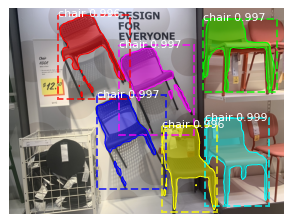

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


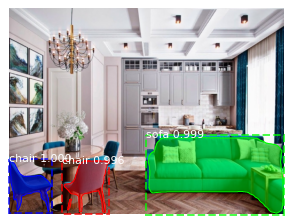

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


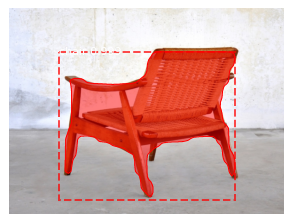

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


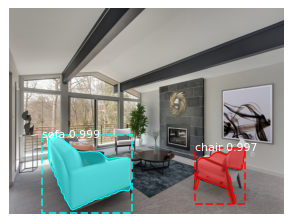

Processing 1 images
image                    shape: (544, 900, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  900.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


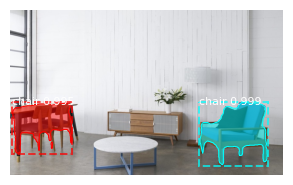

Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


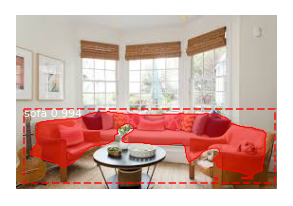

Processing 1 images
image                    shape: (134, 376, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


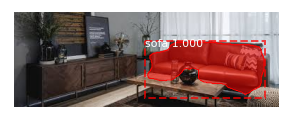

Processing 1 images
image                    shape: (155, 324, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


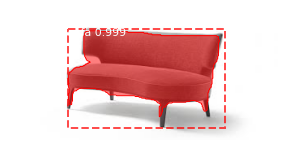

In [14]:
import skimage

real_test_dir = './dataset/real_test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                dataset_val.class_names, r['scores'], figsize=(5, 5))

In [16]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps = \
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("mAP: ", np.mean(APs))

mAP:  0.6970476198196411
